<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/Task3_Semantic_segmentation_model_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 任务目标
+ 了解语义分割网络模型的发展：FCN 、SegNet、Unet、DeepLab、RefineNet、PSPNet、GAN语义分割。
+ 语义分割模型的使用
+ 语义分割模型的原理和训练过程


### FCN原理及网络结构

FCN首先将一幅RGB图像输入到卷积神经网络后，经过多次卷积以及池化过程得到一系列的特征图，然后利用反卷积层对最后一个卷积层得到的特征图进行上采样，使得上采样后特征图与原图像的大小一样，从而实现对特征图上的每个像素值进行预测的同时保留其在原图像中的空间位置信息，最后对上采样特征图进行逐像素分类，逐个像素计算softmax分类损失。

主要特点：

+ 不含全连接层（FC）的全卷积（Fully Conv）网络。从而可适应任意尺寸输入。

+ 引入增大数据尺寸的反卷积（Deconv）层。能够输出精细的结果。

+ 结合不同深度层结果的跳级（skip）结构。同时确保鲁棒性和精确性。


### SegNet
Segnet是用于进行像素级别图像分割的全卷积网络，分割的核心组件是一个encoder 网络，及其相对应的decoder网络，后接一个象素级别的分类网络。

encoder网络：其结构与VGG16网络的前13层卷积层的结构相似。decoder网络：作用是将由encoder的到的低分辨率的feature maps 进行映射得到与输入图像featuremap相同的分辨率进而进行像素级别的分类。

Segnet的亮点：decoder进行上采样的方式，直接利用与之对应的encoder阶段中进行max-pooling时的polling index 进行非线性上采样，这样做的好处是上采样阶段就不需要进行学习。 上采样后得到的feature maps 是非常稀疏的，因此，需要进一步选择合适的卷积核进行卷积得到dense featuremaps 。

SegNet的思路和FCN十分相似，只是Encoder，Decoder（Unsampling）使用的技术不一样。SegNet的编码器部分使用的是VGG16的前13层卷积网络，每个编码器层都对应一个解码器层，最终解码器的输出被送入soft-max分类器以独立的为每个像素产生类别概率。


Encoder编码器

+ 在编码器处，执行卷积和最大池化。
+ VGG-16有13个卷积层。 （不用全连接的层）
+ 在进行2×2最大池化时，存储相应的最大池化索引（位置）。

Decoder解码器

使用最大池化的索引进行上采样

+ 在解码器处，执行上采样和卷积。最后，每个像素送到softmax分类器。
+ 在上采样期间，如上所示，调用相应编码器层处的最大池化索引以进行上采样。
+ 最后，使用K类softmax分类器来预测每个像素的类别。

### Unet
U-net对称语义分割模型，该网络模型主要由一个收缩路径和一个对称扩张路径组成，收缩路径用来获得上下文信息，对称扩张路径用来精确定位分割边界。U-net使用图像切块进行训练，所以训练数据量远远大于训练图像的数量，这使得网络在少量样本的情况下也能获得不变性和鲁棒性。

+ Encoder：由两个3x3的卷积层（RELU）+2x2的max pooling层（stride=2）反复组成，每经过一次下采样，通道数翻倍；

+ Decoder：由一个2x2的上采样卷积层（RELU）+Concatenation（crop对应的Encoder层的输出feature map然后与Decoder层的上采样结果相加）+2个3x3的卷积层（RELU）反复构成；

+ 最后一层通过一个1x1卷积将通道数变成期望的类别数。


### DeepLab

基于全卷积对称语义分割模型得到的分割结果比较粗糙，忽略了像素与像素之间的空间一致性关系。于是Google提出了一种新的扩张卷积语义分割模型，考虑了像素与像素之间的空间一致性关系，可以在不增加数量的情况下增加感受野。

+ Deeplabv1是由深度卷积网路和概率图模型级联而成的语义分割模型，由于深度卷积网路在重复最大池化和下采样的过程中会丢失很多的细节信息，所以采用扩张卷积算法增加感受野以获得更多上下文信息。考虑到深度卷积网路在图像标记任务中的空间不敏感性限制了它的定位精度，采用了完全连接条件随机场（Conditional Random Field， CRF）来提高模型捕获细节的能力。
+ Deeplabv2予以分割模型增加了ASPP（Atrous spatial pyramid pooling）结构，利用多个不同采样率的扩张卷积提取特征，再将特征融合以捕获不同大小的上下文信息。
+ Deeplabv3语义分割模型，在ASPP中加入了全局平均池化，同时在平行扩张卷积后添加批量归一化，有效地捕获了全局语义信息。
+ DeepLabV3+语义分割模型在Deeplabv3的基础上增加了编-解码模块和Xception主干网路，增加编解码模块主要是为了恢复原始的像素信息，使得分割的细节信息能够更好的保留，同时编码丰富的上下文信息。增加Xception主干网络是为了采用深度卷积进一步提高算法的精度和速度。在inception结构中，先对输入进行11卷积，之后将通道分组，分别使用不同的33卷积提取特征，最后将各组结果串联在一起作为输出。

主要特点：

+ 在多尺度上为分割对象进行带洞空间金字塔池化（ASPP）
+ 通过使用DCNNs（空洞卷积）提升了目标边界的定位
+ 降低了由DCNN的不变性导致的定位准确率

### 使用segmentation_models_pytorch库 优化baseline


In [3]:
!cp /content/drive/MyDrive/dataset/train.zip /content/

In [5]:
!cp /content/drive/MyDrive/dataset/test_a.zip /content/

In [6]:
!cp /content/drive/MyDrive/dataset/test_a_samplesubmit.csv  /content/

In [7]:
!cp /content/drive/MyDrive/dataset/train_mask.csv  /content/

In [ ]:
!unzip /content/train.zip

In [ ]:
!unzip /content/test_a.zip

In [ ]:
!pip install rasterio

In [1]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A

import rasterio
from rasterio.windows import Window

def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [ ]:
! pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T
import segmentation_models_pytorch as smp

In [3]:
EPOCHES = 20
BATCH_SIZE = 16
IMAGE_SIZE = 224
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
])

In [4]:
class TianChiDataset(D.Dataset):
    def __init__(self, paths, rles, transform, test_mode=False):
        self.paths = paths
        self.rles = rles
        self.transform = transform
        self.test_mode = test_mode
        
        self.len = len(paths)
        self.as_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225]),
        ])
        
    # get data operation
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        if not self.test_mode:
            mask = rle_decode(self.rles[index])
            augments = self.transform(image=img, mask=mask)
            return self.as_tensor(augments['image']), augments['mask'][None]
        else:
            return self.as_tensor(img), ''        
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [5]:
train_mask = pd.read_csv('/content/train_mask.csv', sep='\t', names=['name', 'mask'])
train_mask['name'] = train_mask['name'].apply(lambda x: '/content/train/' + x)

img = cv2.imread(train_mask['name'].iloc[0])
mask = rle_decode(train_mask['mask'].iloc[0])

print(rle_encode(mask) == train_mask['mask'].iloc[0])

True


In [6]:
dataset = TianChiDataset(
    train_mask['name'].values,
    train_mask['mask'].fillna('').values,
    trfm, False
)

In [7]:
valid_idx, train_idx = [], []
for i in range(len(dataset)):
    if i % 5 == 0:
        valid_idx.append(i)
    else:
        train_idx.append(i)
        
train_ds = D.Subset(dataset, train_idx)
valid_ds = D.Subset(dataset, valid_idx)

# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [8]:
def get_model():
    model = smp.UnetPlusPlus(
        encoder_name="efficientnet-b6",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
    )
    
    return model

@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()

In [9]:
model = get_model()
model.to(DEVICE);

optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()
        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*bce+ 0.2*dice

In [ ]:
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'
print(header)

EPOCHES = 10
best_loss = 10
for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in tqdm_notebook(loader):
        # if torch.cuda.is_available():
        #     images, target = images.cuda(), target.cuda()          
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
            # print(loss.item())
        
    vloss = validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(), vloss,
                              (time.time()-start_time)/60**1))
    losses = []
    
    if vloss < best_loss:
        best_loss = vloss
        torch.save(model.state_dict(), 'model_best.pth')

In [11]:
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),
])

subm = []

model.load_state_dict(torch.load("/content/model_best.pth"))
model.eval()

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          56, 14, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          14, 56, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )


In [12]:
test_mask = pd.read_csv('/content/test_a_samplesubmit.csv', sep='\t', names=['name', 'mask'])
test_mask['name'] = test_mask['name'].apply(lambda x: '/content/test_a/' + x)

for idx, name in enumerate(tqdm_notebook(test_mask['name'].iloc[:])):
    image = cv2.imread(name)
    image = trfm(image)
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        score = model(image)[0][0]
        score_sigmoid = score.sigmoid().cpu().numpy()
        score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)
        score_sigmoid = cv2.resize(score_sigmoid, (512, 512))

        
        # break
    subm.append([name.split('/')[-1], rle_encode(score_sigmoid)])

In [13]:
print(subm[0])

['R05K5826G4.jpg', '19 28 531 28 1043 28 1555 28 2067 28 2577 34 3089 34 3599 38 4111 39 4621 42 4664 2 5132 46 5644 46 6154 48 6666 49 7178 50 7690 50 8200 54 8712 55 9224 56 9736 57 10247 59 10758 68 11270 68 11782 84 12294 84 12806 90 13318 91 13830 92 13924 1 13933 1 14342 105 14854 105 15366 118 15878 118 16388 131 16520 2 16899 135 17410 140 17551 1 17554 1 17556 3 17563 1 17921 155 18433 155 18945 176 19457 176 19969 183 20481 183 20993 185 21179 5 21186 5 21505 199 22017 199 22221 1 22228 1 22529 215 23041 215 23553 233 24065 233 24577 244 25089 245 25601 246 25851 1 26113 251 26625 251 27137 267 27649 267 28161 288 28673 288 29185 294 29480 2 29697 297 30209 298 30509 1 30516 1 30721 309 31233 309 31745 315 32257 25 32283 289 32769 23 32796 299 33281 23 33308 300 33793 23 33820 79 33910 210 34123 1 34305 25 34332 78 34422 214 34820 20 34844 78 34941 1 34944 204 35334 18 35354 80 35457 208 35846 1 35848 2 35851 5 35858 5 35867 79 35970 207 36385 71 36488 210 36897 71 37000 210 

In [14]:
subm = pd.DataFrame(subm)
subm.to_csv('/content/result.csv', index=None, header=None, sep='\t')

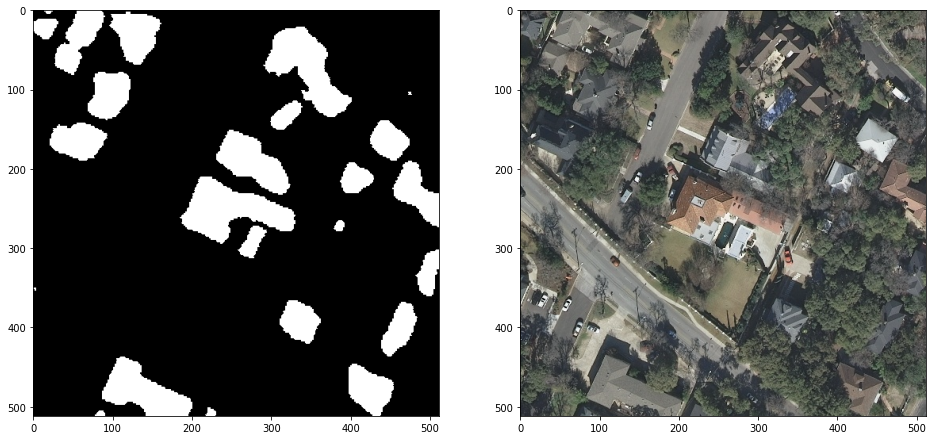

In [19]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(rle_decode(subm[1].fillna('').iloc[20]), cmap='gray')
plt.subplot(122)
plt.imshow(cv2.imread('/content/test_a/' + subm[0].iloc[20]));